In [1]:
import pm4py

## Data Analysis

In [2]:
log = pm4py.read_xes("../data/BPI_Challenge_2019-3-w-after.xes")
event_log = pm4py.convert_to_event_log(log)

print(f"Number of traces: {len(event_log)}")

/Users/I570206/dev/UniMa/PMA/is515-case-group1/.venv/lib/python3.12/site-packages/pm4py/utils.py:986: UserWarning: In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.
  warnings.warn("In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.")


Number of traces: 15182


In [3]:
pm4py.get_start_activities(event_log)

{'SRM: Created': 564,
 'Vendor creates invoice': 356,
 'Vendor creates debit memo': 8,
 'Create Purchase Order Item': 13035,
 'Create Purchase Requisition Item': 1219}

In [4]:
pm4py.get_end_activities(event_log)

{'SRM: Transfer Failed (E.Sys.)': 44,
 'SRM: Change was Transmitted': 38,
 'Change Delivery Indicator': 33,
 'Clear Invoice': 9258,
 'SRM: In Transfer to Execution Syst.': 26,
 'Record Service Entry Sheet': 921,
 'Create Purchase Order Item': 220,
 'Record Invoice Receipt': 1330,
 'Vendor creates debit memo': 1,
 'Change Final Invoice Indicator': 1,
 'SRM: Transaction Completed': 5,
 'Remove Payment Block': 256,
 'Cancel Invoice Receipt': 84,
 'Change Price': 74,
 'Delete Purchase Order Item': 302,
 'Set Payment Block': 58,
 'Record Goods Receipt': 2319,
 'Cancel Goods Receipt': 168,
 'Cancel Subsequent Invoice': 3,
 'Vendor creates invoice': 5,
 'SRM: Deleted': 9,
 'Reactivate Purchase Order Item': 1,
 'Change Quantity': 20,
 'Change Approval for Purchase Order': 6}

In [5]:
df = pm4py.convert_to_dataframe(event_log)

df_duration = df.sort_values(["case:concept:name", "time:timestamp"])

case_durations = (
    df_duration.groupby("case:concept:name")["time:timestamp"]
      .agg(["min", "max"])
      .reset_index()
)

case_durations["duration_seconds"] = (
    case_durations["max"] - case_durations["min"]
).dt.total_seconds()

case_durations["duration_days"] = case_durations["duration_seconds"] / 86400

print(case_durations.head())


  case:concept:name                       min                       max  \
0  2000000001_00001 2018-01-03 08:49:00+00:00 2019-01-17 10:58:00+00:00   
1  2000000002_00001 2018-01-04 13:17:00+00:00 2019-01-17 10:59:00+00:00   
2  2000000005_00002 2018-01-08 09:08:00+00:00 2018-01-08 10:09:00+00:00   
3  2000000006_00001 2018-01-08 10:33:00+00:00 2019-01-17 10:59:00+00:00   
4  2000000008_00001 2018-01-08 14:36:00+00:00 2018-02-22 15:18:00+00:00   

   duration_seconds  duration_days  
0        32753340.0     379.089583  
1        32650920.0     377.904167  
2            3660.0       0.042361  
3        32315160.0     374.018056  
4         3890520.0      45.029167  


In [6]:
# Case duration Mean, Median, Max and Min

print("Mean case duration in days: ",case_durations.duration_days.mean())
print("Median case duration in days: ",case_durations.duration_days.median())
print("Min case duration in days: ",case_durations.duration_days.min())
print("Min case duration in seconds: ",case_durations.duration_seconds.min())
print("Max case duration in days:",case_durations.duration_days.max())

Mean case duration in days:  74.95906126041072
Median case duration in days:  63.422222222222224
Min case duration in days:  0.0
Min case duration in seconds:  0.0
Max case duration in days: 6567.7451388888885


In [7]:
df = df.sort_values(["case:concept:name", "time:timestamp"])

success_cases = df.loc[df["concept:name"] == "Clear Invoice", "case:concept:name"].unique()
df["is_successful"] = df["case:concept:name"].isin(success_cases)

case_durations = (
    df.groupby("case:concept:name")["time:timestamp"]
      .agg(["min", "max"])
      .reset_index()
      .rename(columns={"min": "start_time", "max": "end_time"})
)

case_durations["duration_days"] = (
    (case_durations["end_time"] - case_durations["start_time"]).dt.total_seconds() / 86400
)

case_durations = case_durations.merge(
    df[["case:concept:name", "is_successful"]].drop_duplicates(),
    on="case:concept:name",
    how="left"
)

process_start = case_durations[case_durations["is_successful"]]["start_time"].min()
process_end = case_durations[case_durations["is_successful"]]["end_time"].max()

print("Overall Process Timeline:")
print(f"Start of first case: {process_start}")
print(f"End of last case:   {process_end}")

print()
print("Successful Cases:")
print(case_durations[case_durations["is_successful"]]["duration_days"].describe())
print()
print("Unsuccessful Cases:")
print(case_durations[~case_durations["is_successful"]]["duration_days"].describe())

Overall Process Timeline:
Start of first case: 2001-01-23 22:59:00+00:00
End of last case:   2020-04-09 21:59:00+00:00

Successful Cases:
count    9676.000000
mean      101.222405
std       193.725608
min         7.938889
25%        58.848785
50%        80.556944
75%       106.804514
max      6567.745139
Name: duration_days, dtype: float64

Unsuccessful Cases:
count    5506.000000
mean       28.805027
std        55.753611
min         0.000000
25%         0.001389
50%         0.049653
75%        34.044444
max       371.999306
Name: duration_days, dtype: float64


In [8]:
filtered_log = pm4py.filter_activities_rework(event_log, "Clear Invoice")

In [9]:
print(f"Number of traces: {len(filtered_log)}")

Number of traces: 1011


In [15]:
filtered_log

[{'attributes': {'(case) Spend area text': 'Marketing', '(case) Goods Receipt': True, '(case) Spend classification text': 'NPR', '(case) Name': 'vendor_0009', '(case) Purchasing Document': 2000000010, 'creator': 'Fluxicon Disco', '(case) Vendor': 'vendorID_0009', '(case) Company': 'companyID_0000', 'concept:name': '2000000010_00001', '(case) GR-Based Inv. Verif.': True, '(case) Item Category': '3-way match, invoice after GR', '(case) Document Type': 'EC Purchase order', '(case) Purch. Doc. Category name': 'Purchase order', '(case) Item': 1, '(case) Source': 'sourceSystemID_0000', 'variant': 'Variant 578', '(case) Sub spend area text': 'Digital Marketing', '(case) Item Type': 'Service', 'variant-index': 578}, 'events': [{'User': 'batch_00', 'concept:name': 'SRM: Created', 'lifecycle:transition': 'complete', 'Cumulative net worth (EUR)': 1668264.0, 'time:timestamp': Timestamp('2018-01-09 14:30:00+0000', tz='UTC'), 'org:resource': 'batch_00', 'case:(case) Spend area text': 'Marketing', 'c

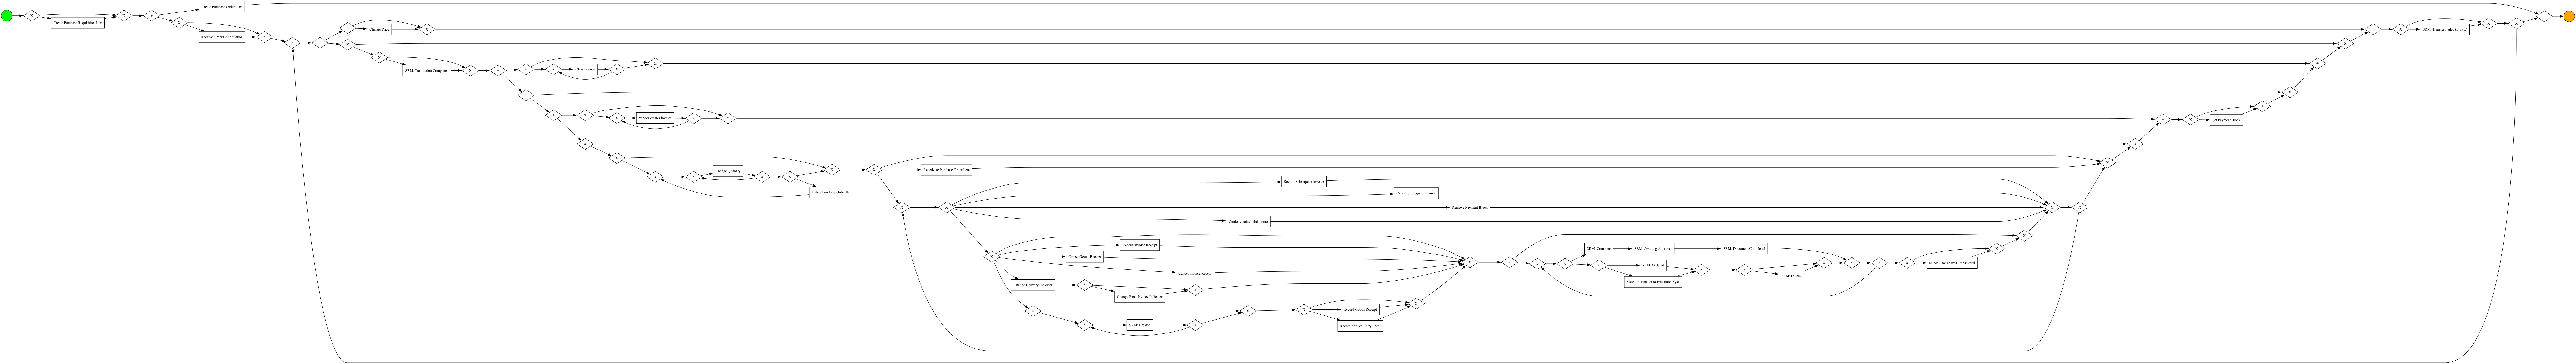

In [12]:
process_tree = pm4py.discover_process_tree_inductive(filtered_log)

bpmn_model = pm4py.convert_to_bpmn(process_tree)

pm4py.view_bpmn(bpmn_model)